In [68]:

# --- CONFIGURAÇÃO DO AMBIENTE E CARREGAMENTO DOS DADOS ---

import pandas as pd  # manipulação e análise de dados em DataFrames
import numpy as np # para operações matemáticas
import seaborn as sns # visualização de dados estatísticos 
import matplotlib.pyplot as plt # personalização básica de gráficos
import re # trabalhar com expressões regulares (será usado para extrair os números das faixas salariais, ignorando textos como "R$")
import warnings # controlar a exibição de avisos

# Configurações globais para os gráficos para garantir consistência visual.
sns.set_theme(style="whitegrid", font_scale=1.1)
PALETA_CORES = sns.color_palette('viridis', 7)
PALETA_BINARIA = {'Computação/TI': '#440154', 'Migrante de Outra Área': '#21918c'}

caminho_do_arquivo = "/kaggle/input/state-of-data-brazil-20242025/Final Dataset - State of Data 2024 - Kaggle - df_survey_2024.csv"

df = pd.read_csv(caminho_do_arquivo)
print("Dataset carregado com sucesso!")
print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    display(df.head())

Dataset carregado com sucesso!
O dataset tem 5217 linhas e 403 colunas.


,0.a_token,0.d_data/hora_envio,1.a_idade,1.a.1_faixa_idade,1.b_genero,1.c_cor/raca/etnia,1.d_pcd,1.e_experiencia_profissional_prejudicada,1.e.1_Não acredito que minha experiência profissional seja afetada,"1.e.2_Sim, devido a minha Cor/Raça/Etnia",...,"8.d.3_Entrando em contato com os times de negócio para definição do problema, identificar a solução e apresentação de resultados.",8.d.4_Desenvolvendo modelos de Machine Learning com o objetivo de colocar em produção em sistemas (produtos de dados).,"8.d.5_Colocando modelos em produção, criando os pipelines de dados, APIs de consumo e monitoramento.","8.d.6_Cuidando da manutenção de modelos de Machine Learning já em produção, atuando no monitoramento, ajustes e refatoração quando necessário.","8.d.7_Realizando construções de dashboards em ferramentas de BI como PowerBI, Tableau, Looker, Qlik, etc.","8.d.8_Utilizando ferramentas avançadas de estatística como SAS, SPSS, Stata etc, para realizar análises.","8.d.9_Criando e dando manutenção em ETLs, DAGs e automações de pipelines de dados.",8.d.10_Criando e gerenciando soluções de Feature Store e cultura de MLOps.,"8.d.11_Criando e mantendo a infra que meus modelos e soluções rodam (clusters, servidores, API, containers, etc.)",8.d.12_Treinando e aplicando LLM's para solucionar problemas de negócio.
0,reb94rv0msth7q4nreb94riaq80iz3yi,16/10/2024 11:19:17,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1zc66g69jjt49y32l1zc66g8wqj79m4e,16/10/2024 20:45:31,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,uu99wmam4n5kc2uu99wmydf0rk7l58f7,17/10/2024 18:10:59,18,17-21,Masculino,Parda,Não,Não acredito que minha experiência profissiona...,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3ynsw7z0hl5hhpbfvaeqk73ynsw7z04l,22/10/2024 18:03:00,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,v6bji2ct5xckpl1uouv6bjiotkrf3b4f,23/10/2024 01:33:23,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# A vantagem inesperada: um estudo sobre os migrantes de carreira em dados

## INTRODUÇÃO

O mercado de dados brasileiro é conhecido por sua diversidade, não apenas em papéis, mas nas origens de seus profissionais. Muitos talentos vêm de áreas que, tradicionalmente, não estavam ligadas à tecnologia. Essa é uma realidade que muitos de nós na comunidade vivemos: a transição de carreira. Mas essa jornada traz consigo uma série de dúvidas.

Esta análise investiga a jornada dos "migrantes de carreira" para responder as perguntas:

1.  **DE ONDE VÊM?** Qual é a real diversidade de formação acadêmica na área de dados?
2.  **PARA ONDE VÃO?** A área de formação original influencia o cargo que um profissional alcança?
3.  **QUANTO GANHAM?** Existe uma "penalidade" ou "bônus" salarial por vir de uma área que não seja de Computação/TI?

Vamos usar os dados da State of Data Brazil para derrubar mitos e descobrir o verdadeiro valor da diversidade de conhecimento em nosso mercado.

In [70]:
# --- FASE 1: PREPARAÇÃO DOS DADOS PARA A ANÁLISE DE MIGRAÇÃO ---

# Colunas de interesse para esta tese
colunas_migrantes = {
    '1.b_genero': 'genero',
    '1.m_área_de_formação': 'formacao',
    '2.f_cargo_atual': 'cargo',
    '2.g_nivel': 'senioridade',
    '2.h_faixa_salarial': 'salario_faixa'
}

df_migrantes = df[list(colunas_migrantes.keys())].rename(columns=colunas_migrantes)

# --- FASE 2: LIMPEZA E ENRIQUECIMENTO DOS DADOS ---

# Remover registros com dados ausentes nas colunas essenciais para a tese
df_migrantes = df_migrantes.dropna()
print(f"Após remover todos os nulos, restaram {df_migrantes.shape[0]} linhas para análise.")

# Agrupar áreas de formação para simplificar a análise
mapa_formacao = {
    'Computação / Engenharia de Software / Sistemas de Informação/ TI': 'Computação/TI',
    'Outras Engenharias (não incluir engenharia de software ou TI)': 'Outras Engenharias',
    'Economia/ Administração / Contabilidade / Finanças/ Negócios': 'Negócios/Finanças',
    'Estatística/ Matemática / Matemática Computacional/ Ciências Atuariais': 'Exatas (Estat./Mat.)',
    'Marketing / Publicidade / Comunicação / Jornalismo / Ciências Sociais': 'Humanas/Comunicação',
    'Ciências Biológicas/ Farmácia/ Medicina/ Área da Saúde': 'Saúde/Biológicas',
    'Química / Física': 'Ciências Naturais'
}
df_migrantes['formacao_grupo'] = df_migrantes['formacao'].map(mapa_formacao)

# Filtrar categorias não específicas ou com poucos dados para manter o foco
df_migrantes = df_migrantes.dropna(subset=['formacao_grupo']) 
df_migrantes = df_migrantes[df_migrantes['cargo'] != 'Outra Opção']

# Focamos em 'Masculino' e 'Feminino' para uma comparação binária direta
df_migrantes = df_migrantes[df_migrantes['genero'].isin(['Masculino', 'Feminino'])]
print(f"Após agrupar e limpar, temos {df_migrantes.shape[0]} linhas para análise.")

# Função para converter faixas salariais em média da faixa
def converter_salario(faixa):
    if pd.isna(faixa): return None
    numeros = re.findall(r'\d+\.?\d*', faixa.replace('.', ''))
    numeros_int = [int(n) for n in numeros]
    if 'Menos de' in faixa and numeros_int: return numeros_int[0]
    elif 'Acima de' in faixa and numeros_int: return numeros_int[0]
    elif len(numeros_int) == 2: return (numeros_int[0] + numeros_int[1]) / 2
    else: return None

df_migrantes['salario_numerico'] = df_migrantes['salario_faixa'].apply(converter_salario)

# --- FASE 3: VERIFICAÇÃO FINAL ---
print("\n### Amostra do DataFrame para a tese de 'Migrantes de Carreira':")
display(df_migrantes.sample(5))

Após remover todos os nulos, restaram 3750 linhas para análise.
Após agrupar e limpar, temos 3312 linhas para análise.

### Amostra do DataFrame para a tese de 'Migrantes de Carreira':


,genero,formacao,cargo,senioridade,salario_faixa,formacao_grupo,salario_numerico
2175,Masculino,Outras Engenharias (não incluir engenharia de ...,Analista de Dados/Data Analyst,Sênior,de R$ 12.001/mês a R$ 16.000/mês,Outras Engenharias,14000.5
1574,Masculino,Economia/ Administração / Contabilidade / Fina...,Data Product Manager/ Product Manager (PM/APM/...,Sênior,de R$ 16.001/mês a R$ 20.000/mês,Negócios/Finanças,18000.5
3134,Feminino,Economia/ Administração / Contabilidade / Fina...,Analista de Dados/Data Analyst,Júnior,de R$ 4.001/mês a R$ 6.000/mês,Negócios/Finanças,5000.5
4782,Feminino,Economia/ Administração / Contabilidade / Fina...,Analista de Negócios/Business Analyst,Sênior,de R$ 6.001/mês a R$ 8.000/mês,Negócios/Finanças,7000.5
2397,Masculino,Computação / Engenharia de Software / Sistemas...,Engenheiro de Machine Learning/ML Engineer/AI ...,Pleno,de R$ 8.001/mês a R$ 12.000/mês,Computação/TI,10000.5


### ATO I - O MAPA DAS ORIGENS

O primeiro passo é entender a composição do nosso mercado. O background em Computação/TI ainda é dominante ou a migração de outras áreas já é uma realidade consolidada?

O gráfico a seguir quantifica a origem dos profissionais de dados no Brasil.

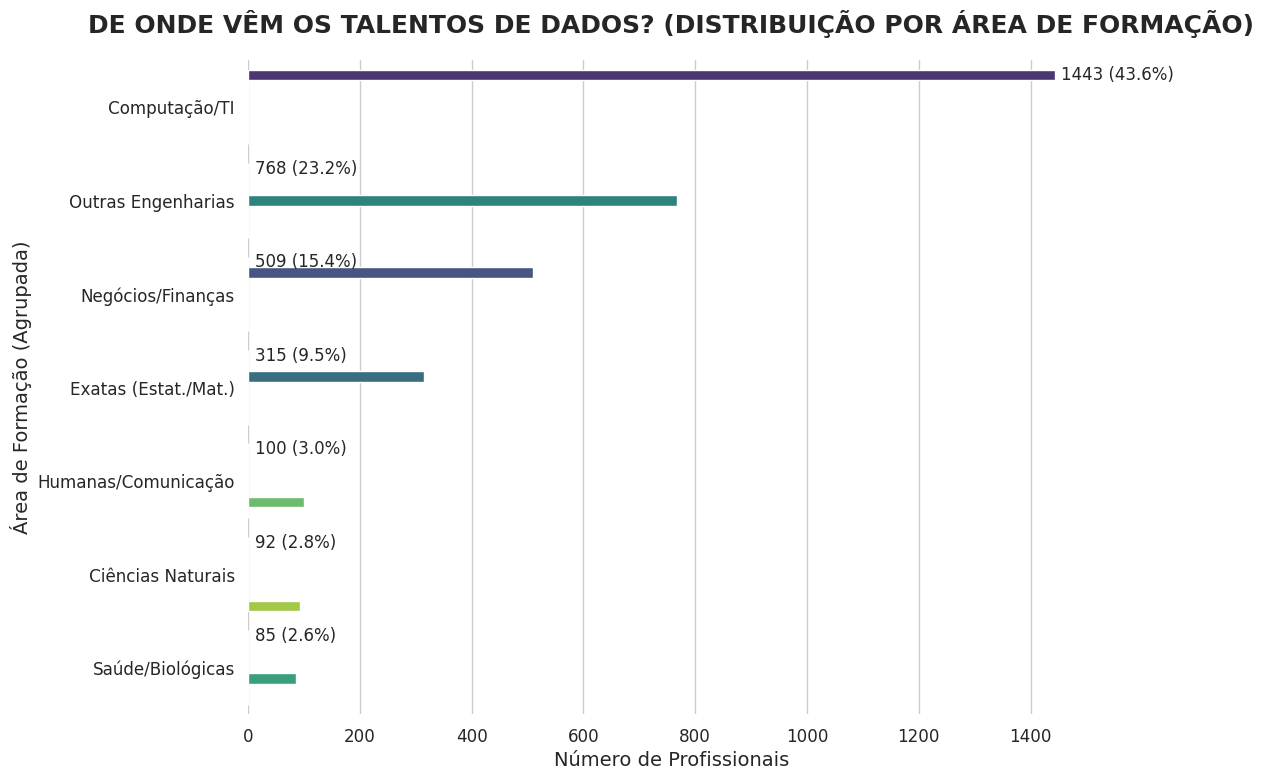

In [71]:
# --- ATO I - O MAPA DAS ORIGENS ---

# Calcula a contagem absoluta de profissionais por área de formação.
contagem_formacao = df_migrantes['formacao_grupo'].value_counts()
# Calcula o percentual correspondente para cada área.
percentual_formacao = df_migrantes['formacao_grupo'].value_counts(normalize=True) * 100

# Define o tamanho da figura para melhor visualização.
plt.figure(figsize=(12, 8))

# Cria o gráfico de contagem horizontal usando Seaborn.
ax1 = sns.countplot(
    data=df_migrantes,
    y='formacao_grupo',
    order=contagem_formacao.index,  # Ordena as barras da maior para a menor.
    palette=PALETA_CORES,           # Aplica a paleta de cores pré-definida.
    hue='formacao_grupo'            # Usa a própria categoria para colorir e evitar um warning.
)

# Remove a legenda, que é redundante neste tipo de gráfico.
ax1.legend_.remove()

# Define os títulos e rótulos dos eixos para dar contexto ao gráfico.
ax1.set_title('DE ONDE VÊM OS TALENTOS DE DADOS? (DISTRIBUIÇÃO POR ÁREA DE FORMAÇÃO)', fontsize=18, weight='bold', pad=20)
ax1.set_xlabel('Número de Profissionais', fontsize=14)
ax1.set_ylabel('Área de Formação (Agrupada)', fontsize=14)

# --- Anotações no Gráfico ---

# Cria uma lista de rótulos combinando contagem e percentual.
labels = [f'{c} ({p:.1f}%)' for c, p in zip(contagem_formacao, percentual_formacao)]

# Aplica os rótulos criados a cada barra do gráfico de forma automática e alinhada.
ax1.bar_label(ax1.containers[0], labels=labels, padding=5, fontsize=12)

# --- Finalização da Plotagem ---

# Remove as bordas superior e direita do gráfico para um visual mais limpo.
sns.despine(left=True, bottom=True)

# Ajusta o layout para garantir que todos os elementos fiquem visíveis.
plt.tight_layout()

# Exibe o gráfico final.
plt.show()

###  Principais observações sobre as origens

**BASE TÉCNICA FORTE**  
O mercado ainda é predominantemente formado por talentos de **Computação/TI (43,6%)** e **Outras Engenharias (23,2%)**, que somados representam **quase 67% dos profissionais**. A base técnica tradicional continua sendo a principal fonte de talentos.

**A MIGRAÇÃO É RELEVANTE**  
A presença significativa de áreas como **Negócios/Finanças (15,4%)** e **Exatas (9,5%)** demonstra que a transição de carreira não é uma exceção, mas uma **realidade consolidada**. Juntos, os "migrantes" de áreas não-TI já compõem uma parcela **substancial e competitiva** do mercado.


### ATO II - AS ROTAS DE MIGRAÇÃO

Sabendo a origem, a pergunta natural é sobre o destino. Existe um caminho profissional preferencial para quem vem de Negócios, Exatas ou Humanas?

O mapa de calor abaixo mostra, em porcentagem, qual cargo cada grupo de formação tende a ocupar, revelando as principais **"rotas de migração"** para a área de dados.

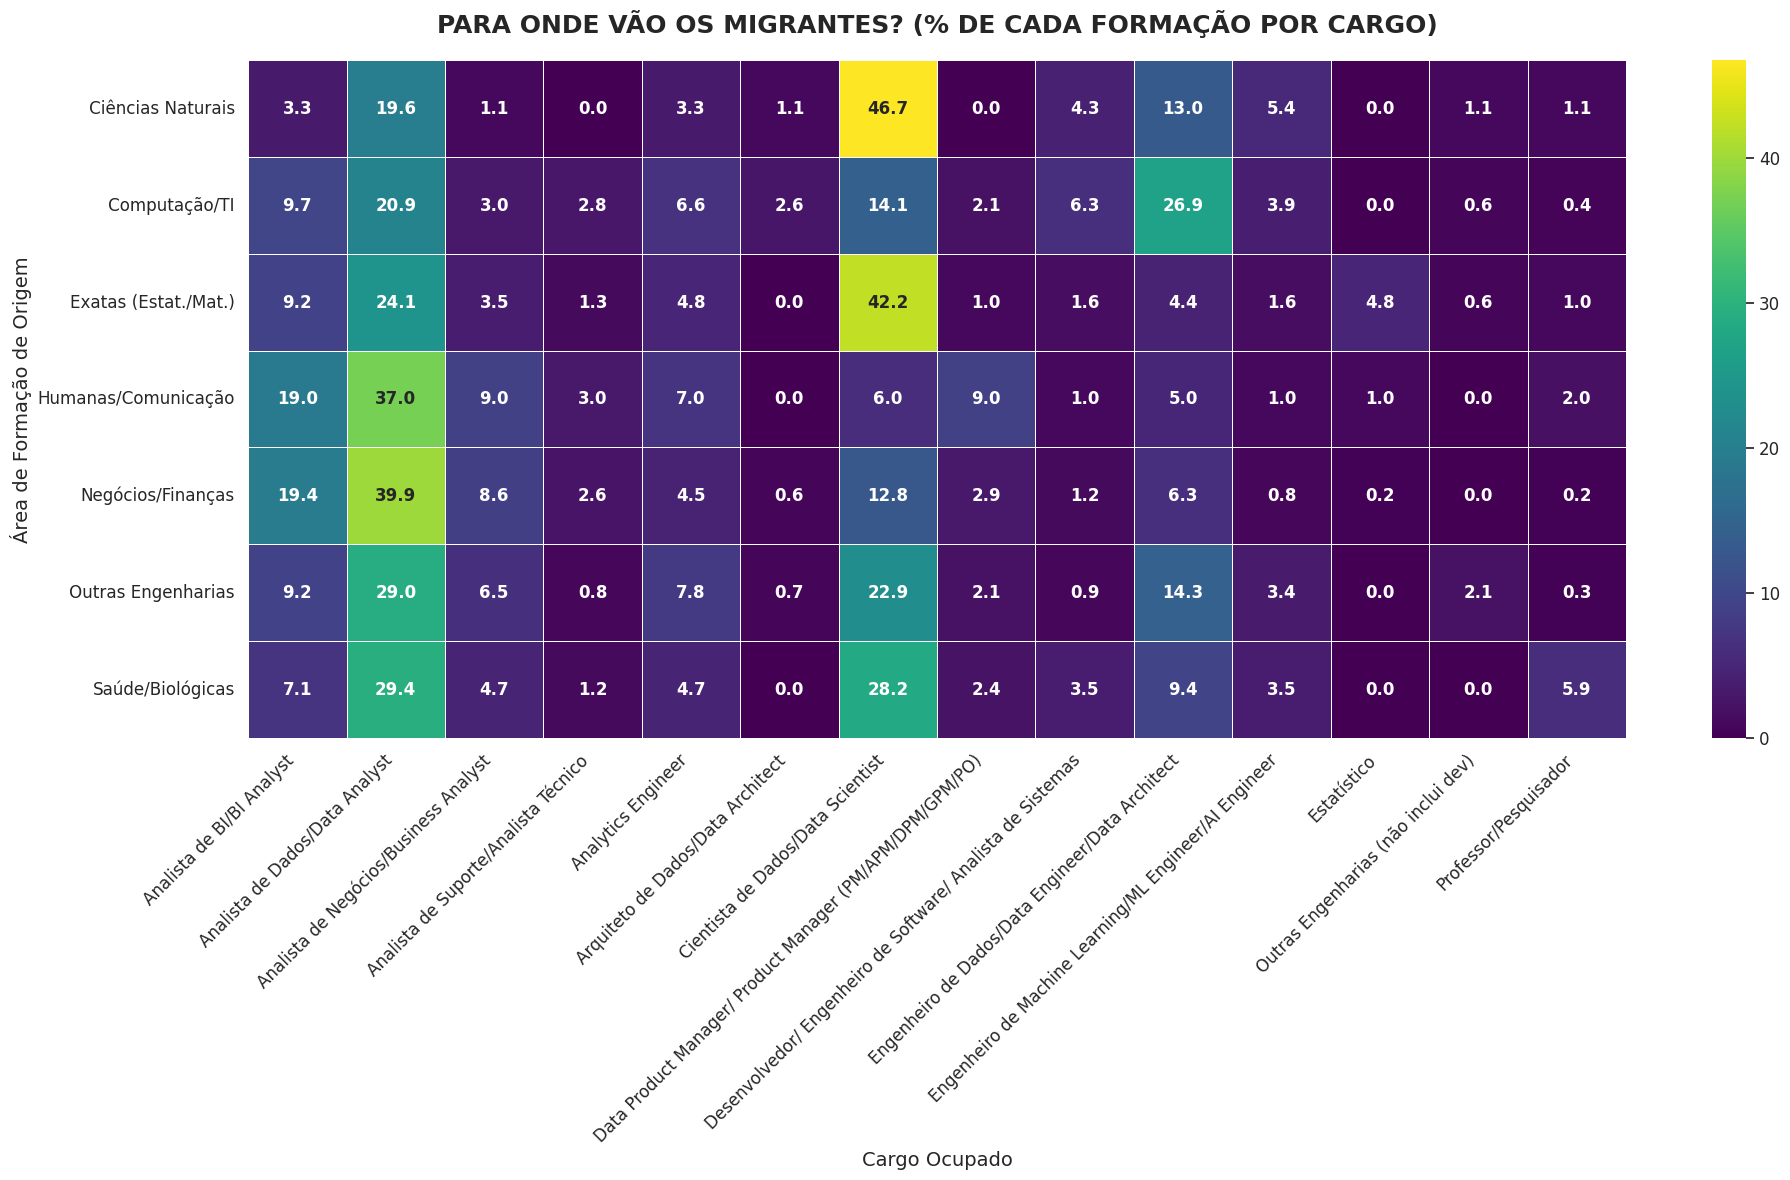

In [73]:
# --- ATO II - AS ROTAS DE MIGRAÇÃO ---

# Cria uma tabela cruzada (crosstab) para analisar a distribuição percentual dos cargos por área de formação.
crosstab_formacao_cargo = pd.crosstab(
    df_migrantes['formacao_grupo'],   # Linhas do crosstab.
    df_migrantes['cargo'],            # Colunas do crosstab.
    normalize='index'                 # Calcula a proporção por linha (cada área de formação soma 100%).
) * 100                               # Converte a proporção para percentual.

# --- Visualização do Gráfico ---

# Define o tamanho da figura.
plt.figure(figsize=(20, 12))

# Cria o mapa de calor (heatmap) para visualizar a tabela de cruzamento.
ax2 = sns.heatmap(
    crosstab_formacao_cargo,
    annot=True,                     # Exibe os valores percentuais em cada célula.
    fmt='.1f',                      # Formata os valores com uma casa decimal.
    cmap='viridis',                 # Define a escala de cores do mapa.
    linewidths=.5,                  # Adiciona uma pequena linha entre as células.
    annot_kws={"size": 12, "weight": "bold"} # Personaliza a fonte das anotações.
)

# --- Personalização do Gráfico ---

# Define o título principal e os rótulos dos eixos.
ax2.set_title('PARA ONDE VÃO OS MIGRANTES? (% DE CADA FORMAÇÃO POR CARGO)', fontsize=18, weight='bold', pad=20)
ax2.set_xlabel('Cargo Ocupado', fontsize=14)
ax2.set_ylabel('Área de Formação de Origem', fontsize=14)

# Rotaciona os rótulos do eixo X para melhor legibilidade.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ajusta o layout para evitar sobreposição de elementos.
plt.tight_layout()

# Exibe o mapa de calor.
plt.show()

###  Rotas de migração reveladas

> **Leitura:** A linha representa a área de formação (100%), e os valores nas colunas mostram o percentual de profissionais daquela área que ocupam cada cargo.

**A ANÁLISE É A PORTA DE ENTRADA**  
Cargos como **Analista de Dados** e **Analista de BI** são o destino mais comum para quase todas as áreas, especialmente para quem vem de **Negócios/Finanças (59,3%)** e **Humanas/Comunicação (56,0%)**, funcionando como uma ponte para o mercado.

**O "CLUBE" DA CIÊNCIA DE DADOS**  
A carreira de **Cientista de Dados** é a rota principal para quem vem de formações com forte base quantitativa. É o destino de **46,7%** dos profissionais de **Ciências Naturais** e **42,2%** dos de **Exatas**, confirmando a necessidade de uma base matemática/estatística robusta.

**A TRILHA DA ENGENHARIA**  
O cargo de **Engenheiro de Dados** é majoritariamente ocupado por quem já tem um background em **Computação/TI (26,9%)**, sugerindo ser uma carreira que exige uma especialização técnica mais profunda e menos comum para migrantes de outras áreas.

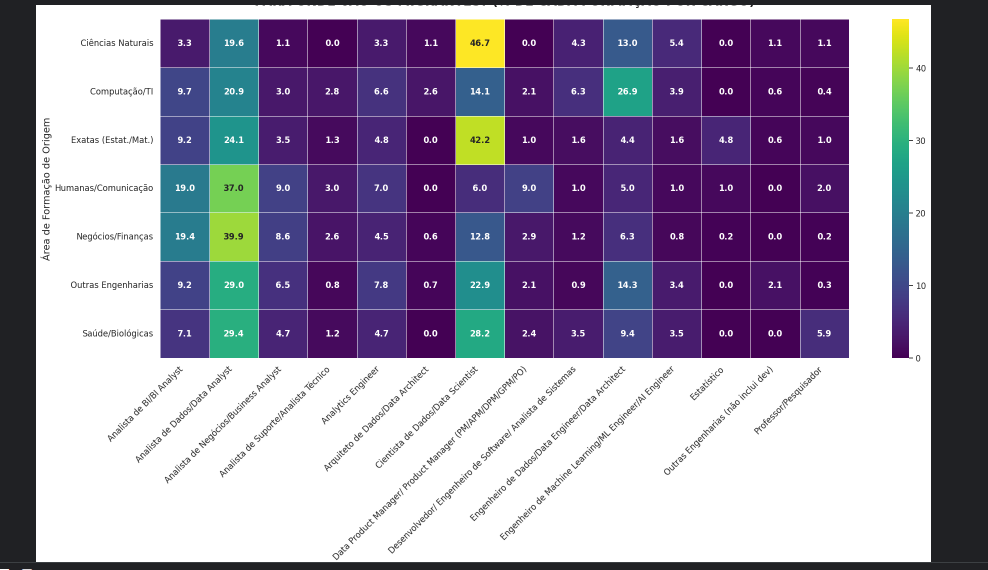

### ATO III - O "IMPOSTO" OU "BÔNUS" DA MIGRAÇÃO

Esta é a análise central: **a formação de origem impacta a remuneração?**

Para garantir uma comparação justa, focamos nos três cargos mais populosos e comparamos os salários médios. Isso nos ajudará a responder se existe um "imposto" ou, surpreendentemente, um "bônus" por ser um migrante de carreira.

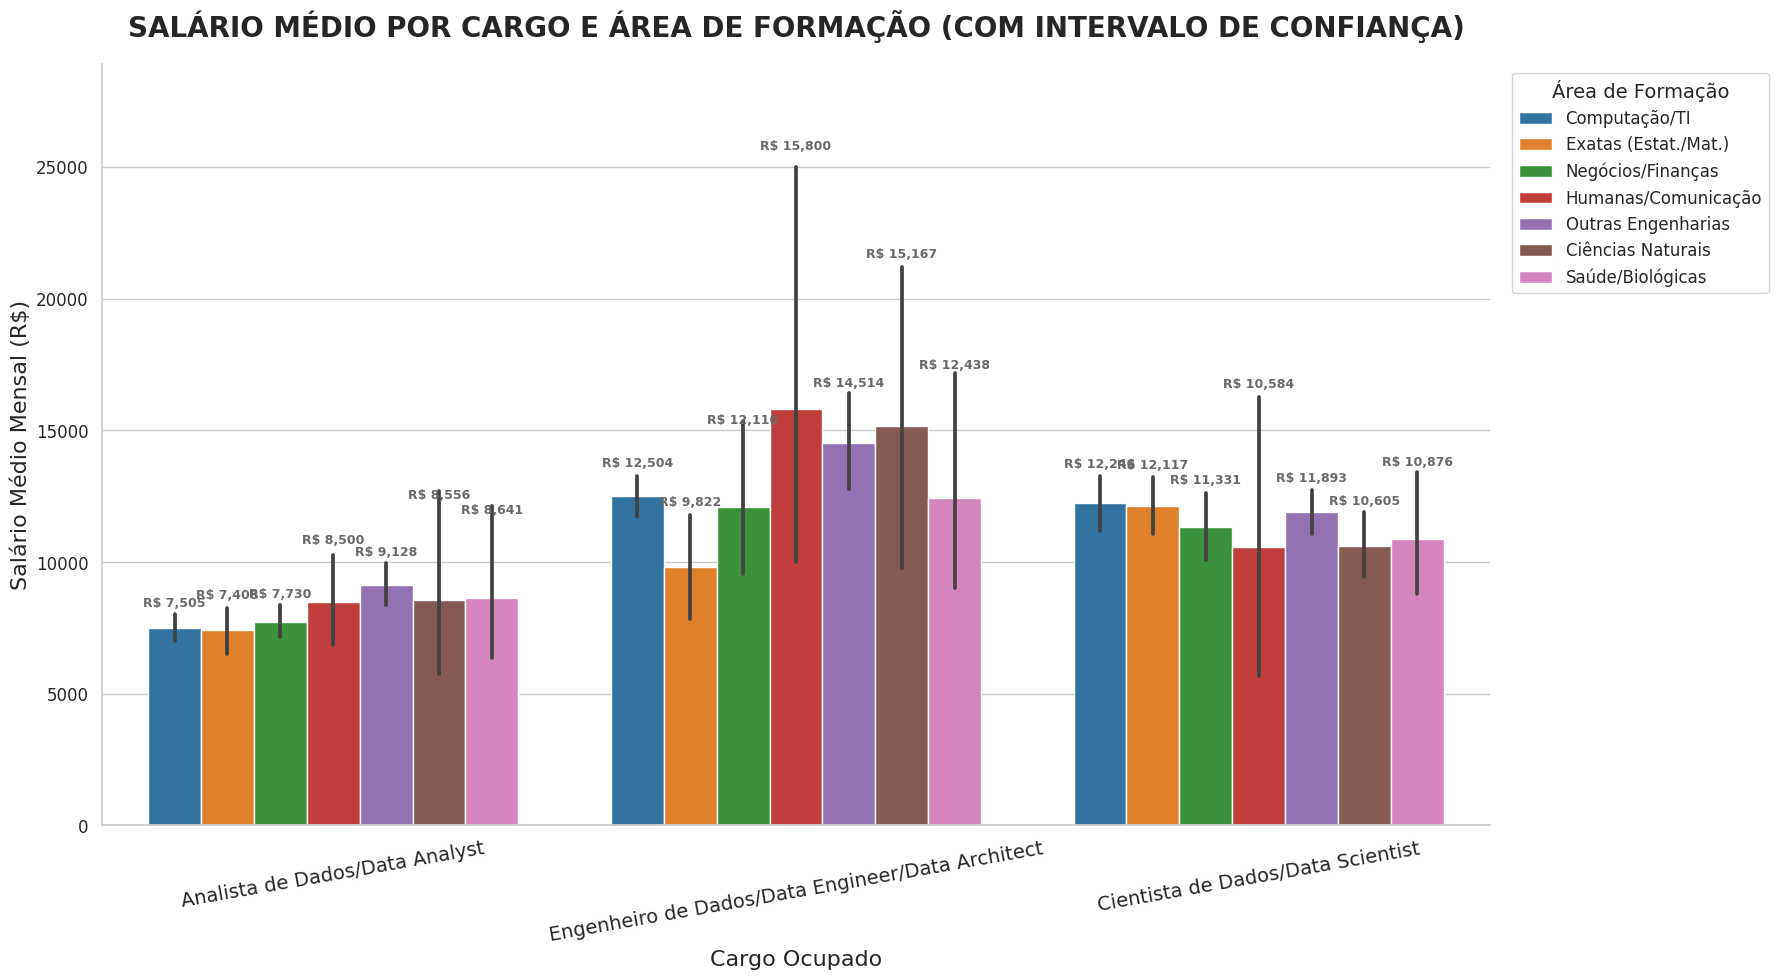

In [78]:
# --- ATO III: O IMPACTO DA FORMAÇÃO NO SALÁRIO ---

# Filtra o DataFrame para focar nos 3 cargos mais populares para uma comparação justa.
cargos_para_analise_salarial = [
    'Analista de Dados/Data Analyst',
    'Engenheiro de Dados/Data Engineer/Data Architect',
    'Cientista de Dados/Data Scientist'
]
df_analise_salario = df_migrantes[df_migrantes['cargo'].isin(cargos_para_analise_salarial)]

# Pré-calcula média e intervalo de confiança
agg_data = df_analise_salario.groupby(['cargo', 'formacao_grupo'])['salario_numerico'].agg(
    mean='mean',
    std='std',
    count='count'
).reset_index()
agg_data['ci_95_err'] = 1.96 * agg_data['std'] / np.sqrt(agg_data['count'])

# --- Visualização ---

# Define o tamanho da figura 
plt.figure(figsize=(20, 10))

# Cria o gráfico de barras usando Seaborn
ax = sns.barplot(
    data=df_analise_salario,
    x='cargo',
    y='salario_numerico',
    hue='formacao_grupo',
    palette='tab10',  
    errorbar=('ci', 95)  
)

# --- Personalização ---

# Define os títulos e rótulos dos eixos para dar contexto ao gráfico.
ax.set_title('SALÁRIO MÉDIO POR CARGO E ÁREA DE FORMAÇÃO (COM INTERVALO DE CONFIANÇA)', fontsize=20, weight='bold', pad=20)
ax.set_xlabel('Cargo Ocupado', fontsize=16)
ax.set_ylabel('Salário Médio Mensal (R$)', fontsize=16)
plt.xticks(rotation=10, ha='center', fontsize=14)
plt.yticks(fontsize=12)

# Legenda.
plt.legend(title='Área de Formação', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')

# Loop de anotações.
num_hues = len(df_analise_salario['formacao_grupo'].unique())
for i, cargo in enumerate(ax.get_xticklabels()):
    for j in range(num_hues):
        bar = ax.patches[j * len(ax.get_xticklabels()) + i]
        cargo_text = cargo.get_text()
        hue_text = ax.legend_.texts[j].get_text()
        stats = agg_data[(agg_data['cargo'] == cargo_text) & (agg_data['formacao_grupo'] == hue_text)]
        
        if not stats.empty:
            mean_val = stats['mean'].values[0]
            ci_err = stats['ci_95_err'].values[0]
            y_pos = mean_val + ci_err + 200
            
            ax.text(
                x=bar.get_x() + bar.get_width() / 2,
                y=y_pos,
                s=f'R$ {mean_val:,.0f}',
                ha='center',
                va='bottom',
                fontsize=9,
                color='dimgray',
                fontweight='bold'
            )

# --- Plotagem ---

plt.ylim(0, ax.get_ylim()[1] * 1.1)
sns.despine()
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

###  O conhecimento de domínio vale ouro?

> Nota: As barras de erro no gráfico representam o intervalo de confiança de 95% para a média salarial. Se as barras de diferentes grupos se sobrepõem, a diferença entre suas médias pode não ser estatisticamente significativa.

---

#### 1. Convergência salarial na Análise de Dados  
Embora profissionais de Outras Engenharias apresentem a maior média salarial nominal para Analistas de Dados (R$ 9.128), a sobreposição generalizada dos intervalos de confiança com quase todas as outras áreas, incluindo Computação/TI, não permite afirmar uma vantagem financeira clara. Os dados sugerem que, para esta função, o mercado tende a remunerar de forma estatisticamente equivalente profissionais de diferentes origens.

---

#### 2. Volatilidade na Engenharia e o potencial dos nichos  
O cargo de Engenheiro de Dados apresenta a maior dispersão salarial. As médias mais altas aparecem entre profissionais de Humanas (R$ 15.800) e Ciências Naturais (R$ 15.167), mas com intervalos de confiança extremamente amplos, o que indica alta incerteza, provavelmente causada por poucos respondentes nesses grupos. Isso sugere casos pontuais de nicho altamente valorizados, e não uma regra geral do mercado.

---

#### 3. Ciência de Dados: O campo do equilíbrio salarial  
Para Cientistas de Dados, o cenário é de equilíbrio. As médias salariais entre as principais áreas de formação — Computação/TI (R$ 12.117), Exatas (R$ 12.296) e Outras Engenharias (R$ 11.893) — são bastante próximas. As sobreposições nos intervalos de confiança são amplas, indicando que, uma vez no cargo, a formação de origem tem pouco ou nenhum impacto estatisticamente significativo na remuneração.

---

#### 4. O viés persistente  
Mesmo com um aparente equilíbrio salarial entre formações, a pergunta que permanece é: essa equidade vale para todos os grupos sociais? No próximo ato, investigamos como o gênero pode distorcer essa dinâmica e impactar a remuneração.



### ATO IV - UMA ANÁLISE NECESSÁRIA: A LENTE DE GÊNERO NA MIGRAÇÃO

Os dados mostraram que a migração de carreira pode ser vantajosa financeiramente. *Mas essa vantagem se aplica a todos?*

Para aprofundar, investigamos se o ***"bônus da migração"*** para Analistas de Dados se comporta da mesma forma para homens e mulheres.

Focamos só em Analistas porque é onde há dados suficientes. 

--- Investigando se o 'bônus salarial' da migração se aplica igualmente a homens e mulheres ---

### Tabela: Salário Médio para Analistas de Dados por Gênero e Origem da Formação ###


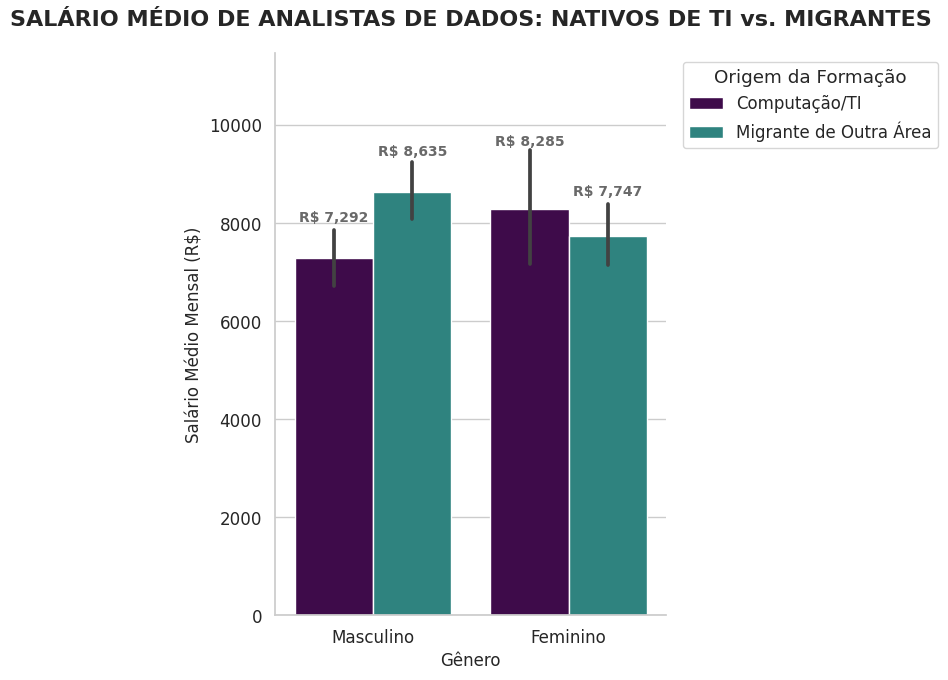

In [76]:
# --- ATO IV: A LENTE DE GÊNERO NA MIGRAÇÃO ---

print("--- Investigando se o 'bônus salarial' da migração se aplica igualmente a homens e mulheres ---\n")

# Filtra o DataFrame para focar apenas no cargo de 'Analista de Dados'.
df_analistas = df_migrantes[df_migrantes['cargo'] == 'Analista de Dados/Data Analyst'].copy()

# Cria uma coluna 'tipo_formacao' para categorizar os profissionais em 'Computação/TI' ou 'Migrante'.
df_analistas['tipo_formacao'] = df_analistas['formacao_grupo'].apply(
    lambda x: 'Computação/TI' if x == 'Computação/TI' else 'Migrante de Outra Área'
)

# Pré-calcula as estatísticas de salário para cada grupo (gênero e tipo de formação).
agg_data_genero = df_analistas.groupby(['tipo_formacao', 'genero'])['salario_numerico'].agg(
    mean='mean', 
    std='std', 
    count='count'
).reset_index()
# Calcula o valor do erro para o intervalo de confiança de 95%.
agg_data_genero['ci_95_err'] = 1.96 * agg_data_genero['std'] / np.sqrt(agg_data_genero['count'])

# Exibe a tabela com os resultados numéricos para referência.
print("### Tabela: Salário Médio para Analistas de Dados por Gênero e Origem da Formação ###")
display(salario_genero_migracao.style.format({'mean': "R$ {:,.2f}"}))

# --- Visualização do Gráfico ---

# Define o tamanho da figura.
plt.figure(figsize=(10, 7))

# Cria o gráfico de barras comparando os salários por gênero e tipo de formação.
ax = sns.barplot(
    data=df_analistas,
    x='genero',
    y='salario_numerico',
    hue='tipo_formacao',
    palette=PALETA_BINARIA,
    errorbar=('ci', 95)  # Exibe as barras de erro com 95% de confiança.
)

# --- Personalização e Anotações ---

# Define os títulos, rótulos e a posição da legenda.
plt.title('SALÁRIO MÉDIO DE ANALISTAS DE DADOS: NATIVOS DE TI vs. MIGRANTES', fontsize=16, weight='bold', pad=20)
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Salário Médio Mensal (R$)', fontsize=12)
plt.legend(title='Origem da Formação', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)

# Itera sobre cada barra do gráfico para adicionar uma anotação de texto.
for i, bar in enumerate(ax.patches):
    # Identifica a qual grupo (gênero e formação) a barra pertence.
    genero = 'Masculino' if bar.get_x() < 0 else 'Feminino'
    tipo_formacao = 'Computação/TI' if i < (len(ax.patches) / 2) else 'Migrante de Outra Área'
    
    # Busca as estatísticas correspondentes a essa barra.
    stats = agg_data_genero[(agg_data_genero['genero'] == genero) & (agg_data_genero['tipo_formacao'] == tipo_formacao)]
    
    # Se encontrar as estatísticas, calcula a posição e adiciona o texto.
    if not stats.empty:
        mean_val = stats['mean'].values[0]
        ci_err = stats['ci_95_err'].values[0]

        # Define a posição vertical do texto acima da barra de erro.
        y_pos = mean_val + ci_err + 100
        
        # Plota o texto com o valor do salário médio no gráfico.
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            y_pos,
            f'R$ {mean_val:,.0f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color='dimgray',
            fontweight='bold'
        )

# --- Finalização da Plotagem ---

# Ajusta os limites e o layout do gráfico.
plt.ylim(0, ax.get_ylim()[1] * 1.15)
sns.despine()
plt.tight_layout(rect=[0, 0, 0.8, 1])

# Exibe o gráfico final.
plt.show()

### Conclusão: A vantagem inesperada e o viés persistente

Nossa análise sobre a jornada dos migrantes de carreira para a área de dados derruba mitos, mas também revela uma verdade complexa sobre como o mercado valoriza (ou não) diferentes perfis.

---

**1. A "penalidade da migração" é um mito — mas o bônus não vale para todos.**  
A descoberta mais impactante é que, para homens, migrar para Análise de Dados a partir de outras áreas está associado a uma vantagem salarial de **18%** em relação aos seus pares com formação em TI. O conhecimento de domínio é, de fato, um bônus.

Para as mulheres, a realidade é oposta. A migração de carreira representa uma **penalidade salarial de 6,5%** em comparação com mulheres nativas de TI. O viés de gênero parece anular — e até reverter — a valorização da experiência diversa, expondo uma falha estrutural persistente no mercado.

---

**2. A Ciência de Dados é quantitativa, mas a valorização é pragmática.**  
Como esperado, as rotas para o cargo de Cientista de Dados são dominadas por formações com forte base quantitativa, como Exatas e Ciências Naturais. No entanto, a remuneração é mais pragmática: as diferenças salariais entre migrantes de outras áreas são mínimas, indicando que a capacidade de aplicar a ciência a problemas de negócio é tão valorizada quanto a pureza teórica da formação.

---

**3. O background diverso pode ser uma "arma secreta" em cargos técnicos.**  
Surpreendentemente, as maiores médias salariais em Engenharia de Dados pertencem a profissionais de Humanas e Ciências Naturais. Embora os dados para esses grupos sejam mais escassos (como indicam as barras de erro), a tendência sugere que habilidades como pensamento crítico, comunicação e uma abordagem sistêmica, quando combinadas à competência técnica, criam profissionais únicos e extremamente valiosos para posições de arquitetura e liderança.

---

**Em resumo:**  
A jornada do migrante de carreira não é uma de desvantagem, mas de **ressignificação de habilidades**. O mercado de dados brasileiro amadureceu ao reconhecer o valor da diversidade de pensamento. Contudo, os dados provam que ele ainda precisa evoluir para garantir que os frutos dessa diversidade sejam distribuídos de forma equitativa, pois **as barreiras estruturais de gênero persistem e distorcem o valor da experiência**.
